# Tracking a spiraling object using the extended / unscented Kalman filter





Consider an object moving in $R^2$.
We assume that we observe a noisy version of its location at each time step.
We want to track the object and possibly forecast its future motion.
We now show how to do this using a simple nonlinear Gaussian SSM, combined with 
various extensions of the Kalman filter algorithm.

Let the hidden state represent
the position  of the object,
$z_t =\begin{pmatrix} u_t &  v_t  \end{pmatrix}$.
(We use $u$ and $v$ for the two coordinates,
to avoid confusion with the state and observation variables.)
We assume the following nonlinear dynamics:

\begin{align*}
z_t &= f(z_{t-1}) + q_t \\
f(\begin{pmatrix} u \\ v \end{pmatrix})
 &= \begin{pmatrix} u + 0.5 \sin(v) \\ v + \cos(u) \end{pmatrix}
\end{align*}

where $q_t \in R^2$ is the process noise, which we assume is Gaussian,
so  $q_t \sim N(0,Q)$.


At each discrete time point we
observe the location corrupted by  Gaussian noise.
Thus the observation model becomes

\begin{align*}
y_t &= h(z_t) + r_t \\
h(\begin{pmatrix} u \\ v \end{pmatrix}) &= \begin{pmatrix} u \\ v \end{pmatrix}
\end{align*}

where $r_t \sim N(0,R)$ is the observation noise.




## Setup

In [1]:


try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [3]:
from jax import numpy as jnp
from jax import random as jr
from matplotlib import pyplot as plt

from dynamax.plotting import  plot_uncertainty_ellipses
from dynamax.nonlinear_gaussian_ssm.nonlinear_gaussian_ssm import NLGSSMParams, NLGSSM
from dynamax.nonlinear_gaussian_ssm.extended_kalman_filter import extended_kalman_filter as ekf
from dynamax.nonlinear_gaussian_ssm.unscented_kalman_filter import unscented_kalman_filter as ukf
from dynamax.nonlinear_gaussian_ssm.unscented_kalman_filter import UKFHyperParams


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


## Create the model

In [4]:

state_dim = 2
obs_dim = 2
f = lambda z: z + 0.4 * jnp.array([jnp.sin(z[1]), jnp.cos(z[0])])
h = lambda z: z

params = dict(
            initial=dict(mean=jnp.array([1.5, 0.0]), cov=jnp.eye(state_dim)),
            dynamics=dict(function = f, cov=jnp.eye(state_dim) * 0.001),
            emissions=dict(function = h, cov=jnp.eye(obs_dim) * 0.05)
        )

nlgssm = NLGSSM(state_dim, obs_dim)


## Sample some data from the model

In [5]:
key = jr.PRNGKey(0)

states, emissions = nlgssm.sample(params, key, num_timesteps=100)


In [6]:
def plot_inference(states, emissions, estimates=None, est_type="", ax=None, title="", aspect=0.8, show_states=True):
    if ax is None:
        fig, ax = plt.subplots()
    if show_states:
        ax.plot(*states.T, label="True States")
    ax.plot(*emissions.T, "ok", fillstyle="none", ms=4, label="Observations")
    if estimates is not None:
        ax.plot(*estimates.T, color="r", linewidth=1.5, label=f"{est_type} Estimate")
    #ax.set_aspect(aspect)
    ax.set_title(title)
    ax.legend(borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    ax.axis('equal')
    return ax

<AxesSubplot:title={'center':'Noisy obervations from hidden trajectory'}>

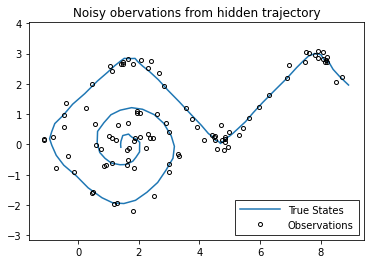

In [7]:
plot_inference(states, emissions, title="Noisy obervations from hidden trajectory")


## Extended Kalman filter



In [8]:

ekf_params = nlgssm.make_inference_args(params)
ekf_post = ekf(ekf_params, emissions)
ekf_means, ekf_covs = ekf_post.filtered_means, ekf_post.filtered_covariances

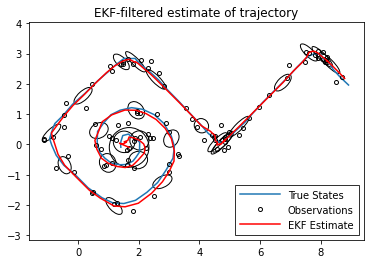

In [9]:


ax = plot_inference(states, emissions, ekf_means, "EKF", title="EKF-filtered estimate of trajectory")
# Add uncertainty ellipses to every fourth estimate
plot_uncertainty_ellipses(ekf_means[::4], ekf_covs[::4], ax)


## Unscented Kalman filter

In [10]:
hyperparams = UKFHyperParams(alpha=10, beta=10, kappa=10)
ukf_params = nlgssm.make_inference_args(params)
ukf_post = ukf(ukf_params, emissions, hyperparams)
ukf_means, ukf_covs = ukf_post.filtered_means, ukf_post.filtered_covariances

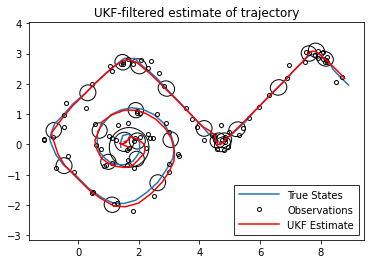

In [11]:


ax = plot_inference(states, emissions, ekf_means, "UKF", title="UKF-filtered estimate of trajectory")
# Add uncertainty ellipses to every fourth estimate
plot_uncertainty_ellipses(ukf_means[::4], ukf_covs[::4], ax)

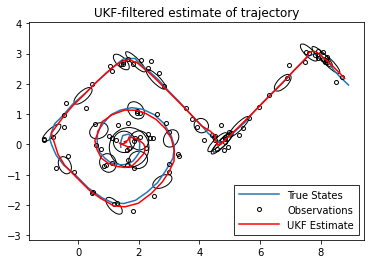

In [12]:
hyperparams = UKFHyperParams() # use defaults
ukf_params = nlgssm.make_inference_args(params)
ukf_post = ukf(ukf_params, emissions, hyperparams)
ukf_means, ukf_covs = ukf_post.filtered_means, ukf_post.filtered_covariances

ax = plot_inference(states, emissions, ekf_means, "UKF", title="UKF-filtered estimate of trajectory")
# Add uncertainty ellipses to every fourth estimate
plot_uncertainty_ellipses(ukf_means[::4], ukf_covs[::4], ax)